In [1]:
# Project 1
# Collaborators: Jackie Bai, Rosalyn Brown & Thomas Scott
#Due Date: June 15th, 2021 (presentation - June 12th)

In [1]:
#We probably won't need all of these, but better to have them.
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from dotenv import load_dotenv
import csv
import requests
from pathlib import Path
import json
from MCForecastTools import MCSimulation
import alpaca_trade_api as tradeapi
import datetime
import time

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import data sets

#Fannie Histrical performance dataset

FM_Hist_Performance = Path('Data/HistoricalPerformance.csv')

#Fannie Orgination dataset

FM_Historical_Origination = Path('Data/HistoricalOrigination.csv')

#St. Louis Fed: Fed Funds Rate

Fed_Funds = Path('Data/FEDFUNDS.csv')

#St. Louis Fed: 30 yr mtg interest rates (remember to weigh against schiller)

Fixed_rate_mtg = Path('Data/Freddie_Mac_30_yr_Fixed_Rate.csv')

#S&P Schiller home price index

Schiller_index = Path('Data/CSUSHPINSA.csv')

In [3]:
# Create dataframes

#Fannie Histrical performance

FM_Hist_Performance_df = pd.read_csv(FM_Hist_Performance, encoding='Latin-1')

#Fannie Orgination

FM_Historical_Origination_df = pd.read_csv(FM_Historical_Origination, encoding='Latin-1')

#St. Louis Fed: Fed Funds Rate

Fed_Funds_df = pd.read_csv(Fed_Funds)

#St. Louis Fed: 30 yr mtg interest rates (remember to weigh against schiller)

Fixed_rate_mtg_df = pd.read_csv(Fixed_rate_mtg)

#S&P Schiller home price index

Schiller_index_df = pd.read_csv(Schiller_index)

In [4]:
#Display sample dataframe

Schiller_index_df.head()

DATE  CSUSHPINSA
0  2000-01-01  104.776083
1  2001-01-01  113.184333
2  2002-01-01  122.286833
3  2003-01-01  133.740750
4  2004-01-01  150.463333

In [5]:
##Merge datasets into consolidated dataframe & drop nulls

Combined_dataframe = pd.concat([FM_Hist_Performance_df, FM_Historical_Origination_df.drop(columns='Unnamed: 0'), Fixed_rate_mtg_df.drop(columns='DATE'), Fed_Funds_df.drop(columns='DATE'), Schiller_index_df.drop(columns='DATE')], axis = 1).dropna()

#Reset index and drop duplicate index
                         
Combined_df = Combined_dataframe.reset_index().drop(columns='index')

#Rename year column

Combined_df.rename(columns = {'Unnamed: 0': 'Year'}, inplace = True)

#Display data

Combined_df.head(21)

#Note to collaborators, all the data/ columns are present in the dataframe. 
#Jupyter just adds the ... to save space and display the data in an abridged format. 
#Try exporting the data to a CSV using 'to_csv' in pandas and you will see what I mean.

Year Number of Records Origination UPB ($M) % Active % Prepay  \
0   2000         1,268,238             $160,749    0.21%   94.34%   
1   2001         3,371,992             $472,779    0.35%   89.92%   
2   2002         3,857,380             $564,732    0.70%   84.44%   
3   2003         5,107,654             $778,021    1.69%   73.00%   
4   2004         1,744,573             $274,074    2.63%   74.07%   
5   2005         1,446,029             $252,240    3.46%   73.89%   
6   2006         1,080,688             $198,677    3.30%   76.35%   
7   2007         1,252,482             $245,737    3.76%   76.42%   
8   2008         1,491,789             $315,022    2.96%   82.55%   
9   2009         2,363,088             $522,072    5.48%   79.26%   
10  2010         1,951,208             $432,356    8.37%   73.44%   
11  2011         1,661,838             $357,697   11.79%   68.62%   
12  2012         2,680,124             $608,106   24.99%   50.68%   
13  2013         2,207,361             $483,403   27.25%   51.61%   
14  2014         1,449,702             $311,589   22.88%   62.94%   
15  2015         1,869,437             $423,209   33.19%   52.76%   
16  2016         2,353,813             $555,052   44.80%   42.32%   
17  2017         2,014,548             $462,000   44.32%   46.44%   
18  2018         1,787,446             $419,622   39.74%   54.53%   
19  2019         2,211,117             $581,664   58.91%   37.44%   
20  2020         4,563,123           $1,279,762   93.54%    5.05%   

   % Repurchase  % TPS % Short Sale  % REO  % NPL  ... Average CLTV  \
0         0.18%  0.10%        0.05%  0.71%  0.01%  ...       77.90%   
1         0.10%  0.08%        0.05%  0.60%  0.02%  ...       73.20%   
2         0.10%  0.09%        0.06%  0.60%  0.03%  ...       69.90%   
3         0.10%  0.16%        0.13%  0.79%  0.07%  ...       67.90%   
4         0.15%  0.25%        0.43%  1.66%  0.15%  ...       70.90%   
5         0.23%  0.38%        1.42%  3.43%  0.27%  ...       71.70%   
6         0.38%  0.39%        2.22%  4.92%  0.34%  ...       72.50%   
7         0.83%  0.38%        2.40%  5.34%  0.42%  ...       74.30%   
8         0.71%  0.19%        1.13%  2.58%  0.23%  ...       73.30%   
9         0.12%  0.05%        0.15%  0.37%  0.05%  ...       67.80%   
10        0.07%  0.03%        0.04%  0.13%  0.03%  ...       68.20%   
11        0.04%  0.02%        0.02%  0.09%  0.02%  ...       69.70%   
12        0.05%  0.02%        0.01%  0.05%  0.01%  ...       70.20%   
13        0.17%  0.02%        0.01%  0.06%  0.01%  ...       73.50%   
14        0.16%  0.03%        0.02%  0.08%  0.01%  ...       77.20%   
15        0.09%  0.02%        0.01%  0.05%  0.00%  ...       75.90%   
16        0.05%  0.01%        0.01%  0.03%  0.00%  ...       74.30%   
17        0.07%  0.01%        0.01%  0.03%  0.00%  ...       76.80%   
18        0.10%  0.01%        0.01%  0.02%  0.00%  ...       78.30%   
19        0.11%  0.00%        0.00%  0.00%  0.00%  ...       76.20%   
20        0.03%  0.00%        0.00%  0.00%  0.00%  ...       71.50%   

   Average DTI Average Note Rate % Investor % Cashout    % CA WA Risk Layers  \
0       35.40%             8.10%      3.60%    14.30%  14.30%           0.68   
1       33.30%             6.85%      3.90%    31.70%  18.10%           0.81   
2       32.90%             6.31%      4.50%    33.70%  19.20%           0.81   
3       32.60%             5.54%      4.50%    34.20%  20.90%           0.81   
4       35.70%             5.69%      4.10%    34.50%  18.20%           0.94   
5       37.60%             5.78%      3.80%    43.40%  14.20%           1.02   
6       38.80%             6.39%      4.90%    42.60%  11.80%           1.07   
7       38.90%             6.33%      6.10%    41.10%  11.70%           1.08   
8       37.90%             5.96%      6.40%    32.00%  18.40%           0.81   
9       33.60%             4.91%      2.90%    31.50%  20.90%           0.56   
10      31.80%             4.54%      4.60

In [4]:
#Define functions

<AxesSubplot:xlabel='Year'>

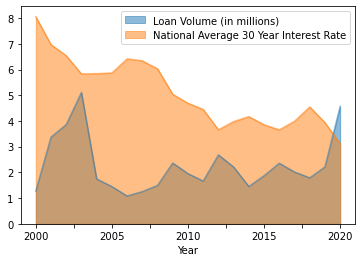

In [6]:
#1. Line plot of total loan volume & interest rate

Set_Rate_as_Index = Combined_df.set_index('Year')

Only_Origination = Set_Rate_as_Index[['Orig. Loan Count', 'MORTGAGE30US']]

Only_Origination['Orig. Loan Count'] = Only_Origination['Orig. Loan Count'].str.replace(',','')

To_Int = Only_Origination[['Orig. Loan Count', 'MORTGAGE30US']].astype(float)

To_Int_Reset_Index = To_Int.reset_index()

To_Int_Reset_Index['Year'] = To_Int_Reset_Index['Year'].astype(str)

To_Int_Reset_Index = To_Int_Reset_Index.set_index('Year')

To_Int_Reset_Index['Loan Volume (in millions)'] = To_Int_Reset_Index['Orig. Loan Count'] / 1000000

To_Int_Reset_Index['National Average 30 Year Interest Rate'] = To_Int_Reset_Index['MORTGAGE30US']

To_Int_Reset_Index = To_Int_Reset_Index.drop(columns = ['Orig. Loan Count', 'MORTGAGE30US'])


Inverse_Plot = To_Int_Reset_Index.plot.area(stacked=False)

Inverse_Plot

                                        Loan Volume (in millions)  \
Loan Volume (in millions)                                1.000000   
National Average 30 Year Interest Rate                  -0.134751   

                                        National Average 30 Year Interest Rate  
Loan Volume (in millions)                                            -0.134751  
National Average 30 Year Interest Rate                                1.000000  


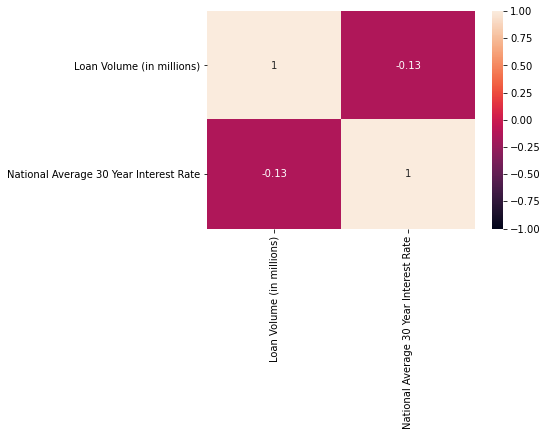

In [7]:
#Show correlation between interest rate and LTV

Loan_Volume_Corr = To_Int_Reset_Index.corr()

print(Loan_Volume_Corr)

Loan_Volume_Corr_Heatmap = sns.heatmap(Loan_Volume_Corr, annot=True, vmax=1, vmin=-1)


<AxesSubplot:xlabel='Year'>

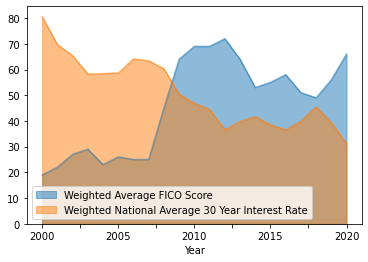

In [12]:
#2. Create line plot of FICO scores for period between 2000-2020 

FICO = Combined_df.set_index('Year')

FICO_Plot = FICO[['Average Borrower FICO', 'MORTGAGE30US']]

FICO_Plot['Weighted Average FICO Score'] = FICO_Plot['Average Borrower FICO'].astype(float) -700 

FICO_Plot['Weighted National Average 30 Year Interest Rate'] = FICO_Plot['MORTGAGE30US'].astype(float) * 10

FICO_Reset_Index = FICO_Plot.reset_index()

FICO_Reset_Index['Year'] = FICO_Reset_Index['Year'].astype(str)

#FICO_Reset_Index

FICO_Line_Plot = FICO_Reset_Index.plot.area('Year', ['Weighted Average FICO Score', 'Weighted National Average 30 Year Interest Rate'], stacked=False)

FICO_Line_Plot

                                                 Weighted Average FICO Score  \
Weighted Average FICO Score                                         1.000000   
Weighted National Average 30 Year Interest Rate                    -0.863102   

                                                 Weighted National Average 30 Year Interest Rate  
Weighted Average FICO Score                                                            -0.863102  
Weighted National Average 30 Year Interest Rate                                         1.000000  


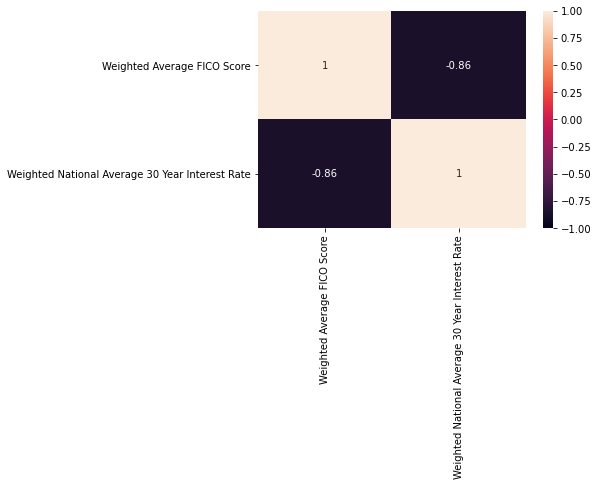

In [9]:
#Show Interest Rate and FICO correlation

Interest_Rate_FICO = FICO_Reset_Index.set_index('Year')

Interest_Rate_FICO = Interest_Rate_FICO.drop(columns = ['Average Borrower FICO','MORTGAGE30US'])

Interest_Rate_FICO_Corr = Interest_Rate_FICO.corr()

print(Interest_Rate_FICO_Corr)

Interest_Rate_FICO_Corr_Plot = sns.heatmap(Interest_Rate_FICO_Corr, annot=True, vmax=1, vmin=-1)

<AxesSubplot:xlabel='Year'>

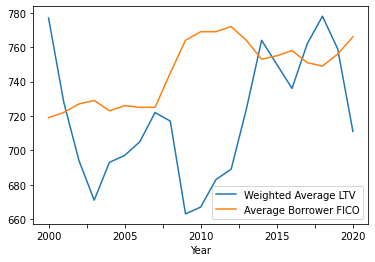

In [13]:
#3. Show line plot for FICO & LTV (remember to remove percentage)

LTV_Compare = Combined_df.set_index('Year')

LTV_Compare_df = LTV_Compare[['Average Borrower FICO', 'Average LTV']]

LTV_Compare_df['Average LTV'] = LTV_Compare_df['Average LTV'].str.replace('%','')

LTV_Compare_df['Weighted Average LTV'] = LTV_Compare_df['Average LTV'].astype(float) * 10

LTV_Compare_df = LTV_Compare_df.drop(columns = ['Average LTV'])

LTV_Compare_df = LTV_Compare_df.reset_index()

LTV_Compare_df['Year'] = LTV_Compare_df['Year'].astype(str)

LTV_Plot = LTV_Compare_df.plot.line('Year', ['Weighted Average LTV', 'Average Borrower FICO'], stacked=False)

LTV_Plot

                       Average LTV  Average Borrower FICO
Average LTV               1.000000              -0.112242
Average Borrower FICO    -0.112242               1.000000


<AxesSubplot:>

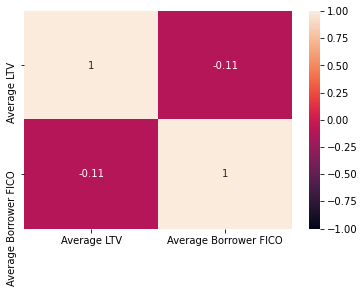

In [11]:
#Plot Correlation

LTV_Compare_Corr = Combined_df[['Average LTV', 'Average Borrower FICO']]

LTV_Compare_Corr['Average LTV'] = LTV_Compare_Corr['Average LTV'].str.replace('%','')

LTV_Compare_Corr['Average LTV'] = LTV_Compare_Corr['Average LTV'].astype(float)

LTV_Compare_Corr['Average Borrower FICO'] = LTV_Compare_Corr['Average Borrower FICO'].astype(float) / 10

Correlation = LTV_Compare_Corr.corr()

print(Correlation)

Correlation_Plot = sns.heatmap(Correlation, annot=True, vmax=1, vmin=-1)

Correlation_Plot


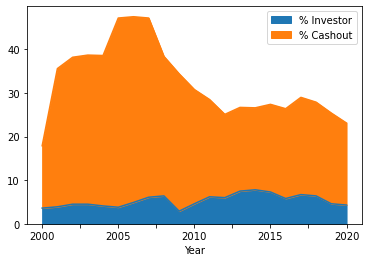

In [15]:
#4. Create stacked area plot of investor property percentage versus cash out refi percentage 

Investor_Property = Combined_df[['Year', '% Investor', '% Cashout']]

Investor_Property['Year'] = Investor_Property['Year'].astype(str)

Investor_Property = Investor_Property.set_index('Year')

Investor_Property['% Investor'] = Investor_Property['% Investor'].str.replace('%','')

Investor_Property['% Investor'] = Investor_Property['% Investor'].astype(float)

Investor_Property['% Cashout'] = Investor_Property['% Cashout'].str.replace('%','')

Investor_Property['% Cashout'] = Investor_Property['% Cashout'].astype(float)

Investor_Property_Plot = Investor_Property.plot.area(stacked=True)



            % Investor  % Cashout
% Investor    1.000000  -0.380133
% Cashout    -0.380133   1.000000


<AxesSubplot:>

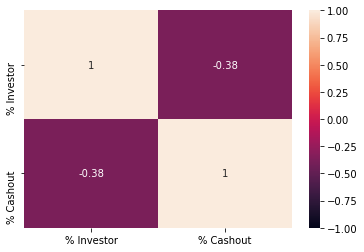

In [16]:
#Plot correlation

Investor_Corr = Investor_Property.corr()

print(Investor_Corr)
Investor_Heatmap = sns.heatmap(Investor_Corr, annot=True, vmax=1, vmin=-1)

Investor_Heatmap

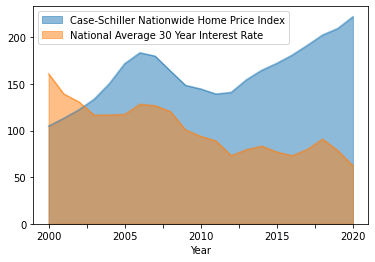

In [18]:
#5. Plot interest rate against the case-schiller home price index (the data should be weighted) 

Schiller_df = Combined_df[['Year', 'Average Note Rate', 'MORTGAGE30US', 'CSUSHPINSA']]

Schiller_df['Average Note Rate'] = Schiller_df['Average Note Rate'].str.replace('%','')

Schiller_df['Average Note Rate'] = Schiller_df['Average Note Rate'].astype(float)

Schiller_df[['Average Fannie Mae Interest Rate', 'National Average 30 Year Interest Rate']] = Schiller_df[['Average Note Rate', 'MORTGAGE30US']] * 20

Schiller_df['Case-Schiller Nationwide Home Price Index'] = Schiller_df['CSUSHPINSA']
    
Schiller_df = Schiller_df.drop(columns = ['Average Note Rate', 'MORTGAGE30US', 'CSUSHPINSA'])

Schiller_df['Year'] = Schiller_df['Year'].astype(str)

Schiller_Plot = Schiller_df.plot.area('Year', ['Case-Schiller Nationwide Home Price Index', 'National Average 30 Year Interest Rate'], stacked = False)


                                           National Average 30 Year Interest Rate  \
National Average 30 Year Interest Rate                                   1.000000   
Case-Schiller Nationwide Home Price Index                               -0.600997   

                                           Case-Schiller Nationwide Home Price Index  
National Average 30 Year Interest Rate                                     -0.600997  
Case-Schiller Nationwide Home Price Index                                   1.000000  


<AxesSubplot:>

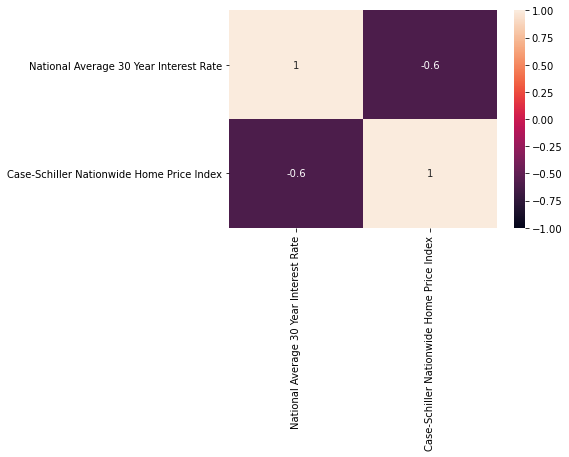

In [19]:
#Plot the correlation

Schiller_Year_Index = Schiller_df.set_index('Year')

Schiller_Corr = Schiller_Year_Index.drop(columns = 'Average Fannie Mae Interest Rate')

Schiller_Corr = Schiller_Corr.corr()

print(Schiller_Corr)

Schiller_Corr_Plot = sns.heatmap(Schiller_Corr, annot=True, vmax=1, vmin=-1)

Schiller_Corr_Plot

<AxesSubplot:xlabel='Year'>

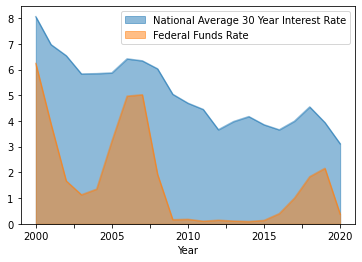

In [16]:
# Create an unstacked area plot showing interest rates against the federal funds rate

Interest_Rate_Comparison = Combined_df[['Year','MORTGAGE30US', 'FEDFUNDS']]

Interest_Rate_Comparison['Year'] = Interest_Rate_Comparison['Year'].astype(str)

Interest_Rate_Comparison = Interest_Rate_Comparison.set_index('Year')

Interest_Rate_Comparison[['National Average 30 Year Interest Rate', 'Federal Funds Rate']] = Interest_Rate_Comparison[['MORTGAGE30US', 'FEDFUNDS']]

Interest_Rate_Comparison = Interest_Rate_Comparison.drop(columns = ['MORTGAGE30US', 'FEDFUNDS'])

Interest_Rate_Area_Plot = Interest_Rate_Comparison.plot.area(stacked=False)

Interest_Rate_Area_Plot


                                        National Average 30 Year Interest Rate  \
National Average 30 Year Interest Rate                                1.000000   
Federal Funds Rate                                                    0.806333   

                                        Federal Funds Rate  
National Average 30 Year Interest Rate            0.806333  
Federal Funds Rate                                1.000000  


<AxesSubplot:>

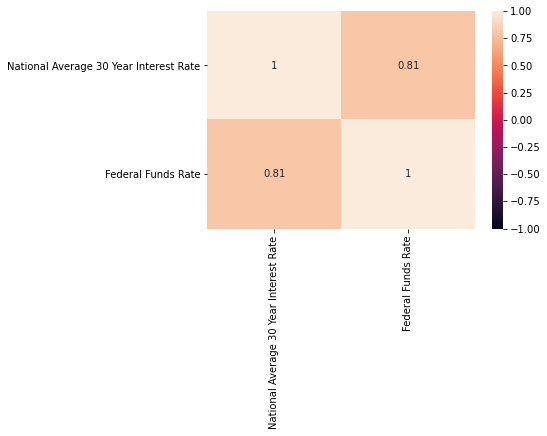

In [17]:
#Show correlation in a seaborn heatmap

Interest_Rate_Correlation = Interest_Rate_Comparison.corr()

print(Interest_Rate_Correlation)

Interest_Rate_Heatmap = sns.heatmap(Interest_Rate_Correlation, annot=True, vmax=1, vmin=-1)

Interest_Rate_Heatmap

                      Origination UPB ($M)  Active UPB ($M)  Average LTV
Origination UPB ($M)              1.000000         0.817893    -0.201687
Active UPB ($M)                   0.817893         1.000000     0.135929
Average LTV                      -0.201687         0.135929     1.000000


<AxesSubplot:>

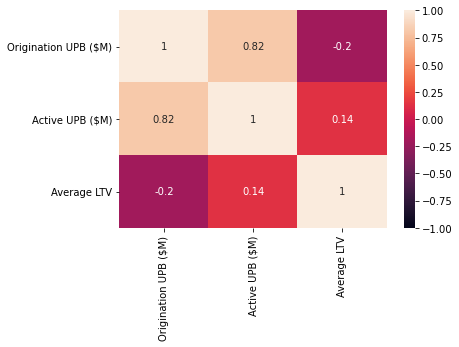

In [20]:
#6. Create a seaborn heatmap showing the percent change of the origination UPB versus percentage change in LTV 

UPB_df = Combined_df[['Origination UPB ($M)', 'Active UPB ($M)', 'Average LTV']]

UPB_df = UPB_df.loc[:,~UPB_df.columns.duplicated()]

UPB_df['Origination UPB ($M)'] = UPB_df['Origination UPB ($M)'].str.replace(r'\W', '')

UPB_df['Active UPB ($M)'] = UPB_df['Active UPB ($M)'].str.replace(r'\W', '')

UPB_df['Average LTV'] = UPB_df['Average LTV'].str.replace('%', '')

UPB_df[['Origination UPB ($M)', 'Active UPB ($M)', 'Average LTV']] = UPB_df[['Origination UPB ($M)', 'Active UPB ($M)', 'Average LTV']].astype(float)

percent_change_corr = UPB_df.corr()

print(percent_change_corr)

percent_change_UPB_heatmap = sns.heatmap(percent_change_corr, annot= True, vmax=1, vmin=-1)

percent_change_UPB_heatmap

<AxesSubplot:xlabel='Year'>

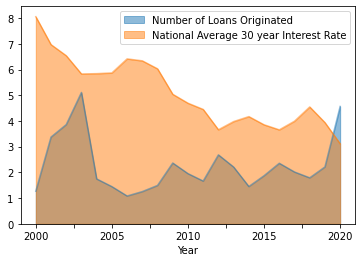

In [23]:
#9. Plot interest rate against number of loans (weight number of loans by dividing by number of million and casting to float) 
#THIS SHOULD BE A DUPLICATE FOR EXERCISE PURPOSES

Loan_Count_df = Combined_df[['Year', 'Orig. Loan Count', 'MORTGAGE30US']]

Loan_Count_df['Number of Loans Originated'] = Loan_Count_df['Orig. Loan Count'].str.replace(',','').astype(float) / 1000000

Loan_Count_df['National Average 30 year Interest Rate'] = Loan_Count_df['MORTGAGE30US']

Loan_Count_df = Loan_Count_df.drop(columns = ['Orig. Loan Count', 'MORTGAGE30US'])

Loan_Count_df['Year'] = Loan_Count_df['Year'].astype(str)

Loan_Count_df = Loan_Count_df.set_index('Year')

Loan_Count_plot = Loan_Count_df.plot.area(stacked=False)

Loan_Count_plot

                                        Number of Loans Originated  \
Number of Loans Originated                                1.000000   
National Average 30 year Interest Rate                   -0.134751   

                                        National Average 30 year Interest Rate  
Number of Loans Originated                                           -0.134751  
National Average 30 year Interest Rate                                1.000000  


<AxesSubplot:>

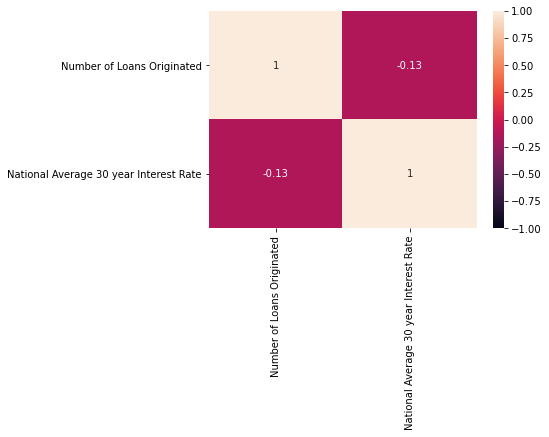

In [24]:
#Plot correlation between origination volume & interest rate

Loan_Count_Corr = Loan_Count_df.corr()

print(Loan_Count_Corr)

Loan_Count_Corr_Plot = sns.heatmap(Loan_Count_Corr, annot=True, vmax=1, vmin=-1)

Loan_Count_Corr_Plot

<AxesSubplot:xlabel='Year'>

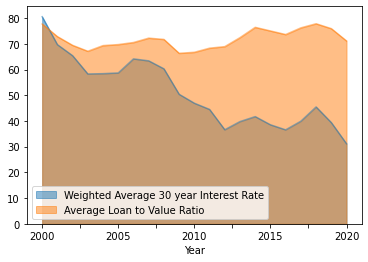

In [25]:
#10. Create area plot of prepayment percentage versus interest rate

prepayment_pct = Combined_df[['Year', 'MORTGAGE30US','Average LTV']]

prepayment_pct['Year'] = prepayment_pct['Year'].astype(str)

prepayment_pct = prepayment_pct.set_index('Year')

prepayment_pct[['Weighted Average 30 year Interest Rate', 'Average Loan to Value Ratio']] = prepayment_pct[['MORTGAGE30US', 'Average LTV']]

prepayment_pct_new = prepayment_pct.drop(columns = ['MORTGAGE30US', 'Average LTV'])

prepayment_pct_new['Average Loan to Value Ratio'] = prepayment_pct_new['Average Loan to Value Ratio'].str.replace('%', '')

prepayment_pct_new['Average Loan to Value Ratio'] = prepayment_pct_new['Average Loan to Value Ratio'].astype(float)

prepayment_pct_new['Weighted Average 30 year Interest Rate'] = prepayment_pct_new['Weighted Average 30 year Interest Rate'] *10

prepayment_pct_plot = prepayment_pct_new.plot.area(stacked=False)

prepayment_pct_plot

                                        Weighted Average 30 year Interest Rate  \
Weighted Average 30 year Interest Rate                                1.000000   
Average Loan to Value Ratio                                          -0.068502   

                                        Average Loan to Value Ratio  
Weighted Average 30 year Interest Rate                    -0.068502  
Average Loan to Value Ratio                                1.000000  


<AxesSubplot:>

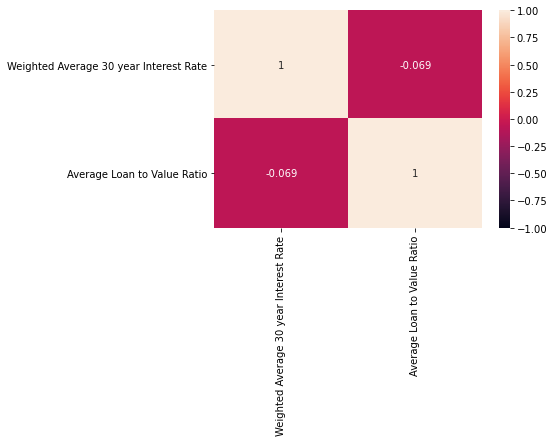

In [26]:
#Show heatmap correlation
prepayment_pct_corr = prepayment_pct_new.corr()
print(prepayment_pct_corr)
prepayment_pct_heatmap = sns.heatmap(prepayment_pct_corr, annot=True, vmax=1, vmin=-1)
prepayment_pct_heatmap

In [27]:
#11. Create dataframe for double axis plot of prepayment versus Case-Schiller index (prepayment down as asset prices increase) 

df11 = Combined_df[['Year', '% Prepay', 'CSUSHPINSA']]
df11['Year'] = df11['Year'].astype(str)

#df11 = df11.set_index('Year')
df11['% Prepay'] = df11['% Prepay'].str.replace(r'%', r'').astype('float')               # convert percentage string to numerical type


In [28]:
#Check Data
df11.head()

Year  % Prepay  CSUSHPINSA
0  2000     94.34  104.776083
1  2001     89.92  113.184333
2  2002     84.44  122.286833
3  2003     73.00  133.740750
4  2004     74.07  150.463333

Text(0, 0.5, 'Case-Schiller Home Price Index')

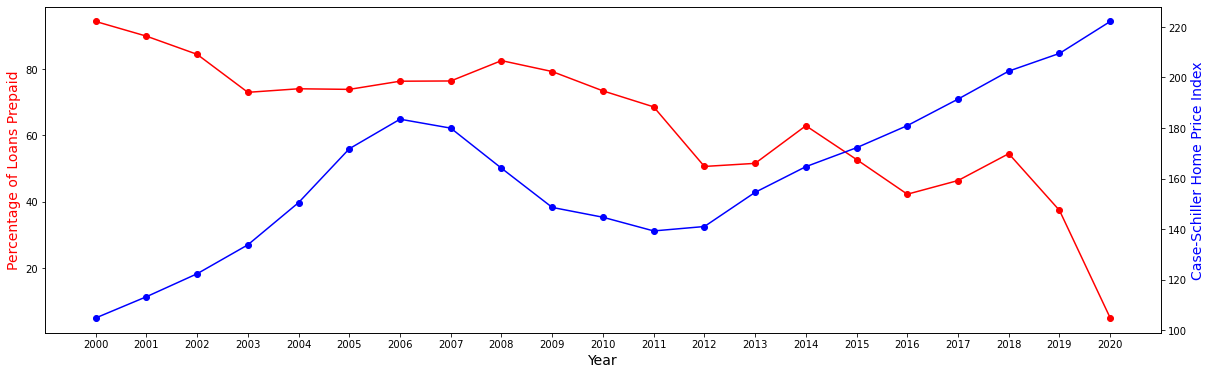

In [29]:
#Plot the dataframe

fig,ax = plt.subplots(figsize=(20,6))

# make a plot

ax.plot(df11.Year, df11['% Prepay'], color="red", marker="o")

# set x-axis label
ax.set_xlabel("Year",fontsize=14)

# set y-axis label
ax.set_ylabel("Percentage of Loans Prepaid",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(df11.Year, df11['CSUSHPINSA'],color="blue",marker="o")
ax2.set_ylabel("Case-Schiller Home Price Index",color="blue",fontsize=14)


Text(0, 0.5, 'Average Loan to Value Ratio')

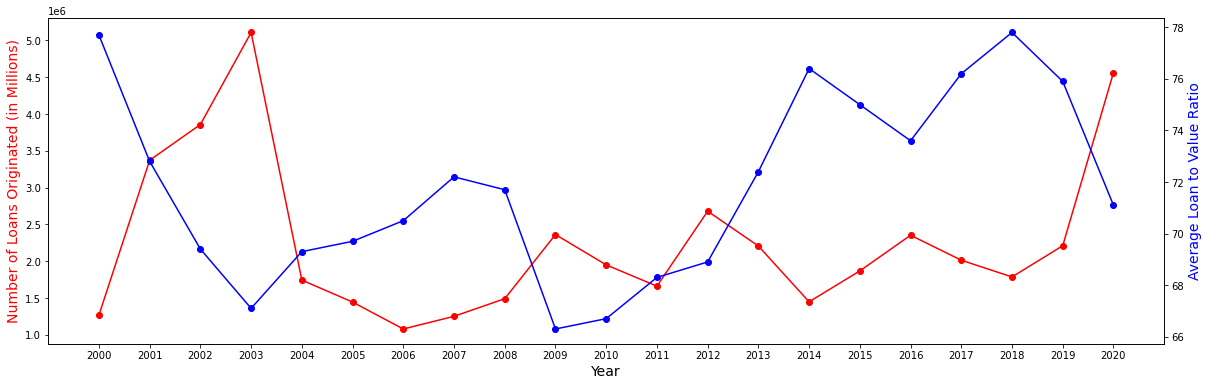

In [30]:
#12. Create a double axis plot loan volume vs. loan value ratio
df12 = Combined_df[['Year', 'Orig. Loan Count', 'Average LTV']]

df12['Year'] = df12['Year'].astype(str)

df12['Average LTV'] = df12['Average LTV'].str.replace(r'%', r'').astype('float')               

# convert percentage string to numerical type
df12['Orig. Loan Count'] = df12['Orig. Loan Count'].str.replace(r',', r'').astype('int')

# Make a figure
fig,ax = plt.subplots(figsize=(20,6))

# make a plot
ax.plot(df12.Year, df12['Orig. Loan Count'], color="red", marker="o")

# set x-axis label
ax.set_xlabel("Year",fontsize=14)

# set y-axis label
ax.set_ylabel("Number of Loans Originated (in Millions)",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(df12.Year, df12['Average LTV'],color="blue",marker="o")
ax2.set_ylabel("Average Loan to Value Ratio",color="blue",fontsize=14)

Text(0, 0.5, 'Average Borrower FICO Score')

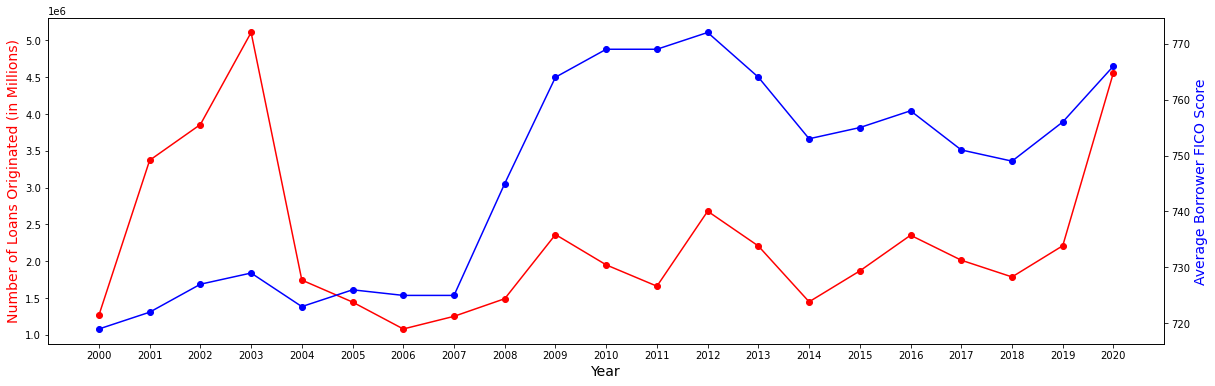

In [31]:
#13. Create a double axis plot of borrower FICO versus Loan volume 

df13 = Combined_df[['Year', 'Average Borrower FICO', 'Orig. Loan Count']]

df13['Year'] = df13['Year'].astype(str)

df13['Orig. Loan Count'] = df13['Orig. Loan Count'].str.replace(r',', r'').astype('int')

# Make a figure
fig,ax = plt.subplots(figsize=(20,6))

# make a plot
ax.plot(df13.Year, df13['Orig. Loan Count'], color="red", marker="o")

# set x-axis label
ax.set_xlabel("Year",fontsize=14)

# set y-axis label
ax.set_ylabel("Number of Loans Originated (in Millions)",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(df13.Year, df13['Average Borrower FICO'],color="blue",marker="o")
ax2.set_ylabel("Average Borrower FICO Score",color="blue",fontsize=14)

Text(0, 0.5, 'Average Loan to Value Ratio')

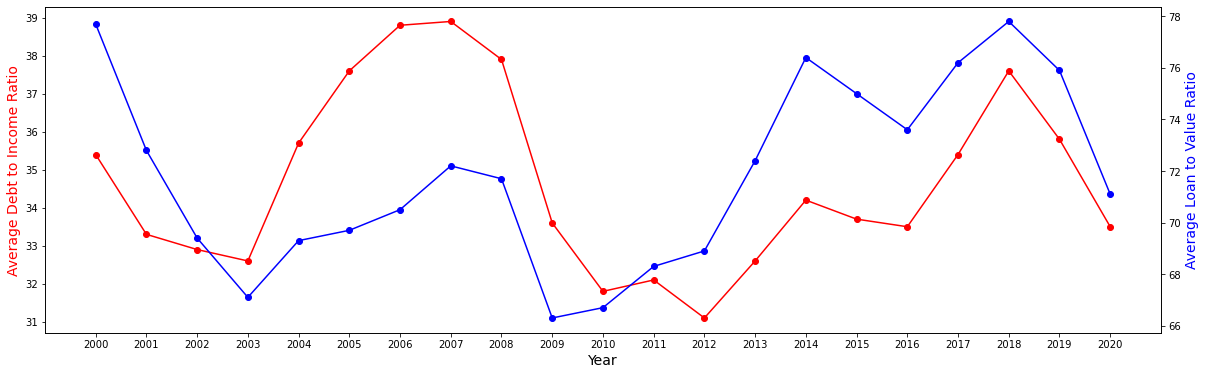

In [32]:
#14. Create a double axis plot of borrower debt to income ratio versus loan to value ratio

df14 = Combined_df[['Year', 'Average DTI', 'Average LTV']]

df14['Year'] = df14['Year'].astype(str)

df14['Average LTV'] = df14['Average LTV'].str.replace(r'%', r'').astype('float') 

df14['Average DTI'] = df14['Average DTI'].str.replace(r'%', r'').astype('float')

fig,ax = plt.subplots(figsize=(20,6))

# make a plot
ax.plot(df14.Year, df14['Average DTI'], color="red", marker="o")

# set x-axis label
ax.set_xlabel("Year",fontsize=14)

# set y-axis label
ax.set_ylabel("Average Debt to Income Ratio",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(df14.Year, df14['Average LTV'],color="blue",marker="o")
ax2.set_ylabel("Average Loan to Value Ratio",color="blue",fontsize=14)


Text(0, 0.5, 'Average Borrower FICO Score')

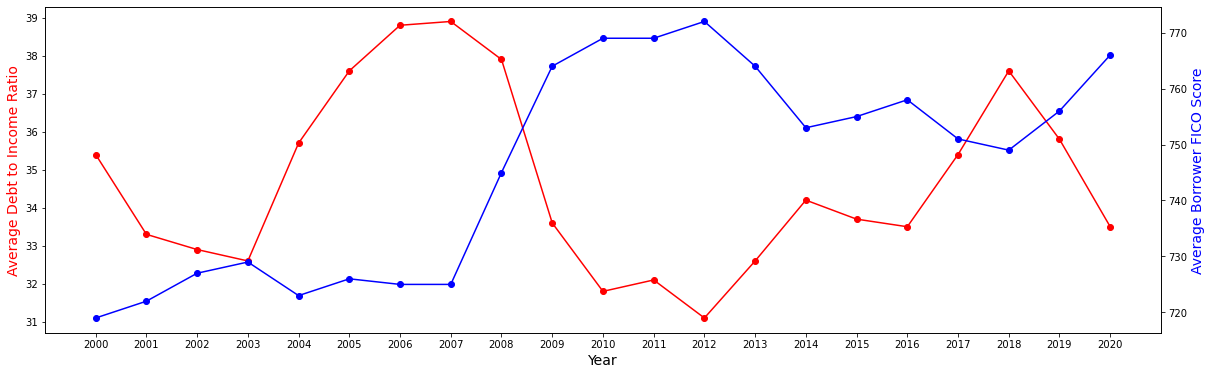

In [33]:
#15. Create a double axis plot of DTI versus borrower FICO

df15 = Combined_df[['Year', 'Average DTI', 'Average Borrower FICO']]

df15['Year'] = df15['Year'].astype(str)

df15['Average DTI'] = df15['Average DTI'].str.replace(r'%', r'').astype('float')

# Make a figure
fig,ax = plt.subplots(figsize=(20,6))

# make a plot
ax.plot(df15.Year, df15['Average DTI'], color="red", marker="o")

# set x-axis label
ax.set_xlabel("Year",fontsize=14)

# set y-axis label
ax.set_ylabel("Average Debt to Income Ratio",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(df15.Year, df15['Average Borrower FICO'],color="blue",marker="o")
ax2.set_ylabel("Average Borrower FICO Score",color="blue",fontsize=14)

In [72]:
#Montecarlo simulation of Case-Schiller using Quandl

In [34]:
#Load (dot)env files
load_dotenv()

Quandl_API_Key = os.getenv('QUANDL_API_KEY')


In [35]:
#Get JSONS & insert environmental variable for Quandl API Key

#Remove or alter based on your own .env path

Nominal_URL = f'https://www.quandl.com/api/v3/datasets/YALE/NHPI.json?api_key={Quandl_API_Key}&collapse=quarterly'
Real_Price_URL = f'https://www.quandl.com/api/v3/datasets/YALE/RHPI.json?api_key={Quandl_API_Key}&collapse=quarterly'
Interest_Rate_URL = f'https://www.quandl.com/api/v3/datasets/FMAC/30US.json?api_key={Quandl_API_Key}&collapse=quarterly'

Get_Schiller_Nominal = requests.get(Nominal_URL)
Get_Schiller_Real_Price = requests.get(Real_Price_URL)
Get_Interest_Rate = requests.get(Interest_Rate_URL)

Nominal_JSON = Get_Schiller_Nominal.json()
Real_Price_JSON =  Get_Schiller_Real_Price.json()
Interest_Rate_JSON = Get_Interest_Rate.json()


Nominal_Index = Nominal_JSON['dataset']['data']
Real_Price_Index = Real_Price_JSON['dataset']['data']
Interest_Rate_Monthly = Interest_Rate_JSON['dataset']['data']

#Convert JSON to Dataframe

Nominal_df = pd.DataFrame(Nominal_Index, columns= ['Date', 'Case-Schiller Nominal Home Price Index'])

Real_Price_df = pd.DataFrame(Real_Price_Index, columns = ['Date', 'Case-Schiller Real Home Price Index'])

Interest_df = pd.DataFrame(Interest_Rate_Monthly, columns = ['Date', 'National 30-Year Fixed Rate Mortgage Average'])

#Normalize dates
Nominal_df['Date'] =  pd.to_datetime(Nominal_df['Date'], format='%Y-%m-%d')

Real_Price_df['Date'] = pd.to_datetime(Real_Price_df['Date'], format='%Y-%m-%d')
                           
Interest_df['Date'] = pd.to_datetime(Interest_df['Date'], format='%Y-%m-%d')

#Cut off entries prior to 2000

Nominal_df = Nominal_df[Nominal_df['Date'] >= '2000-01-01']

Real_Price_df = Real_Price_df[Real_Price_df['Date'] >= '2000-01-01']
                           
Interest_df = Interest_df[Interest_df['Date'] >= '2000-01-01']

Schiller_Combined = pd.merge(Nominal_df, Real_Price_df, on = 'Date')

Schiller_Combined_New = pd.merge(Schiller_Combined, Interest_df, on = 'Date')

#Schiller_Combined_New['National 30-Year Fixed Rate Mortgage Average'] = Schiller_Combined_New['National 30-Year Fixed Rate Mortgage Average'] * 10

Schiller_Combined_New = Schiller_Combined_New.sort_values(by='Date', ascending = True).reset_index().drop(columns = 'index')

Schiller_Combined_New


Date  Case-Schiller Nominal Home Price Index  \
0  2000-03-31                                  101.47   
1  2000-06-30                                  104.85   
2  2000-09-30                                  107.13   
3  2000-12-31                                  108.79   
4  2001-03-31                                  110.39   
..        ...                                     ...   
80 2020-03-31                                  215.26   
81 2020-06-30                                  219.89   
82 2020-09-30                                  226.90   
83 2020-12-31                                  234.32   
84 2021-03-31                                  238.82   

    Case-Schiller Real Home Price Index  \
0                            126.821463   
1                            130.133777   
2                            131.968459   
3                            133.782279   
4                            134.054899   
..                                  ...   
80                           179.648174   
81                           182.386820   
82                           189.362495   
83                           193.508092   
84                           196.330945   

    National 30-Year Fixed Rate Mortgage Average  
0                                           8.23  
1                                           8.22  
2                                           7.88  
3                                           7.13  
4                                           6.91  
..                                           ...  
80                                          3.50  
81                                          3.13  
82                                          2.90  
83                                          2.67  
84                                          3.17  

[85 rows x 4 columns]

Text(0, 0.5, 'National 30-Year Fixed Rate Mortgage Average')

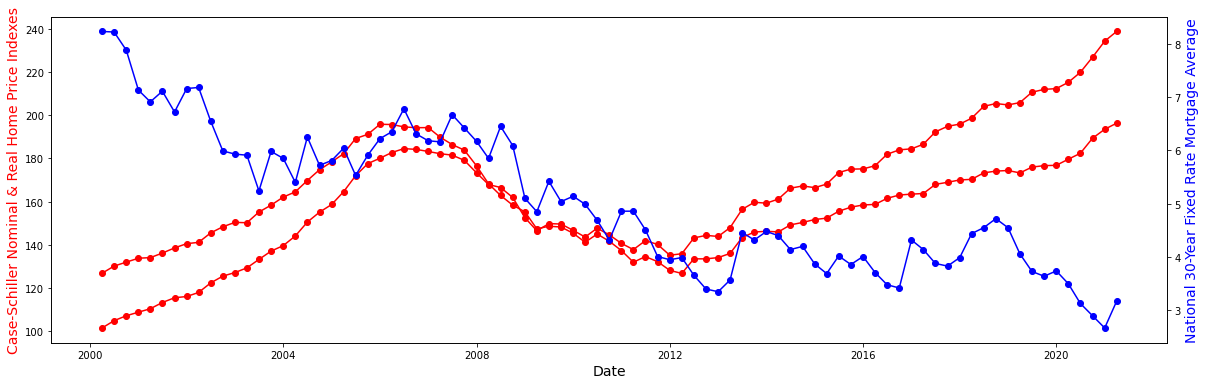

In [36]:
#Plot dataframe
fig,ax = plt.subplots(figsize=(20,6))

# make a plot
ax.plot(Schiller_Combined_New.Date, Schiller_Combined_New[['Case-Schiller Nominal Home Price Index', 'Case-Schiller Real Home Price Index']], color="red", marker="o")

# set x-axis label
ax.set_xlabel("Date",fontsize=14)

# set y-axis label
ax.set_ylabel("Case-Schiller Nominal & Real Home Price Indexes",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(Schiller_Combined_New.Date, Schiller_Combined_New['National 30-Year Fixed Rate Mortgage Average'],color="blue",marker="o")
ax2.set_ylabel("National 30-Year Fixed Rate Mortgage Average",color="blue",fontsize=14)


                                              Case-Schiller Nominal Home Price Index  \
Case-Schiller Nominal Home Price Index                                      1.000000   
Case-Schiller Real Home Price Index                                         0.787721   
National 30-Year Fixed Rate Mortgage Average                               -0.598416   

                                              Case-Schiller Real Home Price Index  \
Case-Schiller Nominal Home Price Index                                   0.787721   
Case-Schiller Real Home Price Index                                      1.000000   
National 30-Year Fixed Rate Mortgage Average                            -0.080302   

                                              National 30-Year Fixed Rate Mortgage Average  
Case-Schiller Nominal Home Price Index                                           -0.598416  
Case-Schiller Real Home Price Index                                              -0.080302  
National 30-Year Fixed Rate

<AxesSubplot:>

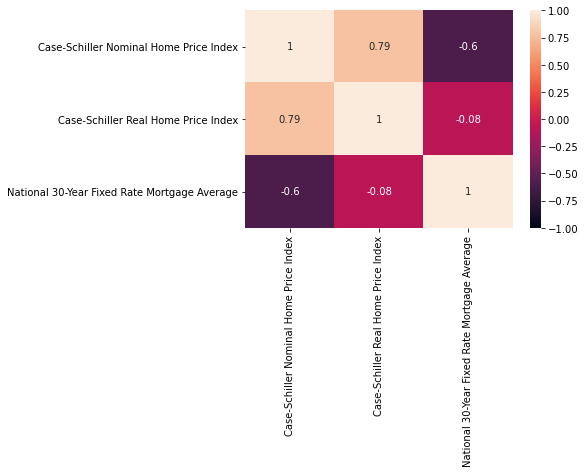

In [37]:
#Show Heatmap Correlation
Schiller_Combined_Set_Index = Schiller_Combined_New.set_index('Date')

Schiller_Combined_Corr = Schiller_Combined_Set_Index.corr()

print(Schiller_Combined_Corr)

Schiller_Combined_Heatmap = sns.heatmap(Schiller_Combined_Corr, annot = True, vmax=1, vmin=-1)

Schiller_Combined_Heatmap

In [74]:
#Run Montecarlo Simulations

In [38]:
#Initialize Alpaca Trade API

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)


In [40]:
# Set date and tickers

todays_date = datetime.date.fromtimestamp(time.time());

#return today's date in ISO format
todays_date_ISOFormat = todays_date.isoformat();

# Set the tickers
tickers = ["MBB", "VMBS","LMBS", "SPMB"]

# Set timeframe to '1M' for Alpaca API
timeframe = "1D"

In [41]:
#Create Dataframe for ETFs
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start = todays_date_ISOFormat,
    end = todays_date_ISOFormat,
    limit=1,
).df

# Display sample data
df_ticker.head()

# Preview DataFrame
df_ticker


LMBS                                   MBB  \
                            open   high    low   close  volume    open   
time                                                                     
2021-06-11 00:00:00-04:00  51.08  51.09  51.05  51.085  815462  108.55   

                                                            SPMB         \
                             high     low   close  volume   open   high   
time                                                                      
2021-06-11 00:00:00-04:00  108.55  108.44  108.46  572776  25.89  25.89   

                                                 VMBS                      \
                             low  close  volume  open   high   low  close   
time                                                                        
2021-06-11 00:00:00-04:00  25.86  25.87  400322  53.4  53.48  53.4  53.46   

                                   
                           volume  
time                               
2021-06-11 00:00:00-04:00  931860

In [42]:
#Set dataset range and print to double check
start_date = pd.Timestamp('2018-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp(str(todays_date_ISOFormat), tz='America/New_York').isoformat()

# Display the 5 year window with the the start and end dates in ISO format
print("Your sample window is as follows:")
print(f"Start date: {start_date}")
print(f"End date: {end_date}")

Your sample window is as follows:
Start date: 2018-01-01T00:00:00-05:00
End date: 2021-06-12T00:00:00-04:00


In [43]:
# Get historical data for selected ETFs

df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000
).df

#drop null values from the dataframe
df_stock_data_drop_nulls = df_stock_data.dropna()

# Display sample data
df_stock_data_drop_nulls.head()

LMBS                                     MBB  \
                            open   high      low   close  volume    open   
time                                                                       
2019-09-23 00:00:00-04:00  51.96  52.02  51.9600  51.990  319087  108.21   
2019-09-24 00:00:00-04:00  52.01  52.04  51.9900  52.040  320975  108.18   
2019-09-25 00:00:00-04:00  51.95  51.98  51.8900  51.905  413802  108.16   
2019-09-26 00:00:00-04:00  51.89  51.93  51.8801  51.890  320245  108.13   
2019-09-27 00:00:00-04:00  51.93  51.96  51.8900  51.910  314817  108.14   

                                                                   SPMB  \
                               high       low   close     volume   open   
time                                                                      
2019-09-23 00:00:00-04:00  108.3058  108.0900  108.10  1839486.0  26.15   
2019-09-24 00:00:00-04:00  108.2400  108.1167  108.22  2655927.0  26.19   
2019-09-25 00:00:00-04:00  108.1900  107.9900  108.07   975356.0  26.27   
2019-09-26 00:00:00-04:00  108.1900  108.0900  108.14   570163.0  26.25   
2019-09-27 00:00:00-04:00  108.2700  108.1000  108.23   675283.0  26.26   

                                                               VMBS           \
                            high      low   close     volume   open     high   
time                                                                           
2019-09-23 00:00:00-04:00  26.26  26.1500  26.250    34999.0  53.18  53.2300   
2019-09-24 00:00:00-04:00  26.31  26.1900  26.305  4202373.0  53.17  53.2163   
2019-09-25 00:00:00-04:00  26.27  26.1700  26.210  3986617.0  53.13  53.1500   
2019-09-26 00:00:00-04:00  26.25  26.2100  26.240  4010128.0  53.15  53.1900   
2019-09-27 00:00:00-04:00  26.26  26.2201  26.240   127526.0  53.16  53.2170   

                                                     
                               low  close    volume  
time                                                 
2019-09-23 00:00:00-04:00  53.1650  53.17  357531.0  
2019-09-24 00:00:00-04:00  53.1400  53.19  434903.0  
2019-09-25 00:00:00-04:00  53.0700  53.10  500809.0  
2019-09-26 00:00:00-04:00  53.1200  53.16  438235.0  
2019-09-27 00:00:00-04:00  53.1538  53.20  425763.0

In [44]:
#Set up Simulation

trading_days_in_year = 252
forecast_years = 10

MC_weighted = MCSimulation(
    portfolio_data = df_stock_data_drop_nulls,
    weights = [.25,.25,.25,.25],
    
    num_simulation = 10,
    
    num_trading_days = trading_days_in_year * forecast_years
)

In [45]:
#Show cumulative returns sample output to evaluate results
MC_return = MC_weighted.calc_cumulative_return()
MC_return

Running Monte Carlo simulation number 0.


0         1         2         3         4         5         6  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.998880  0.999424  0.999844  1.006202  0.999462  1.002851  1.002769   
2     1.001744  0.997534  0.999604  1.002585  1.004037  1.000966  1.001030   
3     1.002777  0.996476  0.996044  1.004504  1.007854  1.003402  1.000916   
4     1.000189  0.995855  0.995308  1.006756  1.009395  1.000866  1.004482   
...        ...       ...       ...       ...       ...       ...       ...   
2516  1.025522  1.241383  0.823440  0.791844  0.926016  0.853104  0.985283   
2517  1.027007  1.244937  0.825849  0.790446  0.923633  0.850682  0.987128   
2518  1.028177  1.246059  0.822179  0.788828  0.925372  0.851494  0.986406   
2519  1.028249  1.244945  0.818115  0.789914  0.922708  0.852670  0.987960   
2520  1.024718  1.245584  0.814998  0.788487  0.923703  0.852957  0.988902   

             7         8         9  
0     1.000000  1.000000  1.000000  
1     1.004267  1.000764  0.997934  
2     1.002906  1.000680  0.996018  
3     1.002145  1.001856  0.997706  
4     1.004879  0.998229  0.998859  
...        ...       ...       ...  
2516  0.967750  0.970455  0.982247  
2517  0.963189  0.974337  0.980350  
2518  0.963727  0.975748  0.985316  
2519  0.960198  0.979317  0.983217  
2520  0.960365  0.980304  0.982700  

[2521 rows x 10 columns]

Running Monte Carlo simulation number 0.


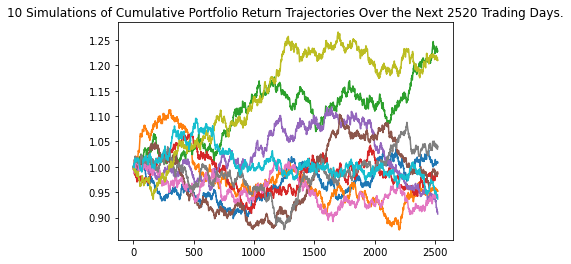

In [65]:
#Run initial simulation to get a feel for the range of possible outputs and results
MC_plot = MC_weighted.plot_simulation()

In [66]:
# Run 500 simulations instead of 10 over the same time period
trading_days_in_year = 252
forecast_years = 10

MC_500_Sim = MCSimulation(
    portfolio_data = df_stock_data_drop_nulls,
    weights = [.25,.25,.25,.25],
    
    num_simulation = 500,
    
    num_trading_days = trading_days_in_year * forecast_years
)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

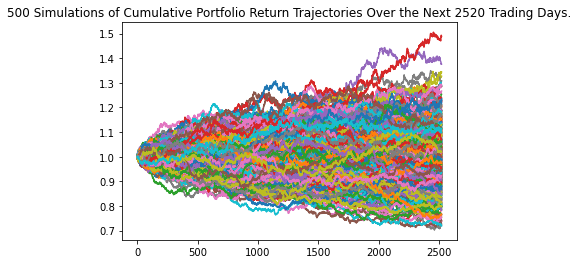

In [67]:
#Run Simulation
MC_500_Plot = MC_500_Sim.plot_simulation()

In [69]:
# Run 500 simulations over a period of 5 years
trading_days_in_year = 252
forecast_years = 5

MC_500_Sim_5_Years = MCSimulation(
    portfolio_data = df_stock_data_drop_nulls,
    weights = [.25,.25,.25,.25],
    
    num_simulation = 500,
    
    num_trading_days = trading_days_in_year * forecast_years
)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

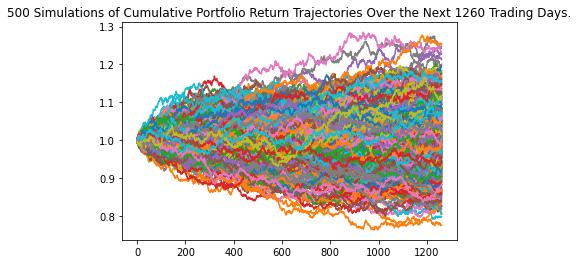

In [70]:
#Run Simulation
MC_500_Sim_5_Years_Plot = MC_500_Sim_5_Years.plot_simulation()